# Bitcoin Price Prediction - LSTM

#### 1. Import Required Dependancies

In [49]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

#### 2. Load Dataset 

In [3]:
df = pd.read_csv('../data/BTC-USD.csv')

In [5]:
df.head()

Date        Open        High         Low       Close   Adj Close  \
0  2015-05-21  234.016006  236.242004  233.835007  235.343994  235.343994   
1  2015-05-22  235.320999  240.968994  235.059998  240.348007  240.348007   
2  2015-05-23  240.285995  241.024994  238.690994  238.871994  238.871994   
3  2015-05-24  238.975998  241.977997  238.811005  240.953003  240.953003   
4  2015-05-25  240.927002  241.020996  236.636993  237.110001  237.110001   

     Volume  
0  15108900  
1  27003000  
2  14605000  
3  11508000  
4  14423900

In [7]:
df.tail()

Date          Open          High           Low         Close  \
3284  2024-05-17  65231.296875  67459.460938  65119.316406  67051.875000   
3285  2024-05-18  67066.210938  67387.328125  66663.500000  66940.804688   
3286  2024-05-19  66937.929688  67694.296875  65937.179688  66278.367188   
3287  2024-05-20  66278.742188  71483.562500  66086.171875  71448.195313   
3288  2024-05-21  71427.992188  71785.109375  70773.343750  71124.765625   

         Adj Close       Volume  
3284  67051.875000  28031279310  
3285  66940.804688  16712277406  
3286  66278.367188  19249094538  
3287  71448.195313  43850655717  
3288  71124.765625  55098576896

In [6]:
df.shape

(3289, 7)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 0 to 3288
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3289 non-null   object 
 1   Open       3289 non-null   float64
 2   High       3289 non-null   float64
 3   Low        3289 non-null   float64
 4   Close      3289 non-null   float64
 5   Adj Close  3289 non-null   float64
 6   Volume     3289 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 180.0+ KB


In [9]:
df.describe()

Open          High           Low         Close     Adj Close  \
count   3289.000000   3289.000000   3289.000000   3289.000000   3289.000000   
mean   17492.488542  17900.652107  17058.290363  17512.708965  17512.708965   
std    18192.482131  18626.696839  17718.041898  18211.605427  18211.605427   
min      210.067993    225.718994    199.567001    210.494995    210.494995   
25%     3421.910400   3495.174805   3372.120117   3448.116943   3448.116943   
50%     9413.004883   9575.544922   9249.500000   9412.612305   9412.612305   
75%    28450.457031  29076.400391  28037.257813  28454.978516  28454.978516   
max    73079.375000  73750.070313  71334.093750  73083.500000  73083.500000   

             Volume  
count  3.289000e+03  
mean   1.850676e+10  
std    1.935494e+10  
min    1.060090e+07  
25%    1.663280e+09  
50%    1.514493e+10  
75%    2.908356e+10  
max    3.509679e+11

#### 3. Pre-Processing

In [11]:
# Check null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [14]:
# Check duplicates
df.duplicated().sum()

0

In [16]:
data = df.drop(df[['Adj Close','Volume']],axis=1)

In [17]:
data.head()

Date        Open        High         Low       Close
0  2015-05-21  234.016006  236.242004  233.835007  235.343994
1  2015-05-22  235.320999  240.968994  235.059998  240.348007
2  2015-05-23  240.285995  241.024994  238.690994  238.871994
3  2015-05-24  238.975998  241.977997  238.811005  240.953003
4  2015-05-25  240.927002  241.020996  236.636993  237.110001

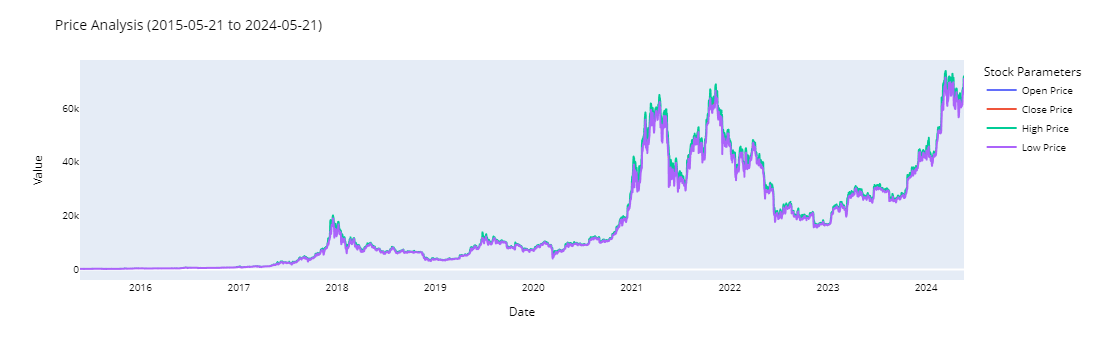

In [20]:
names = cycle(['Open Price','Close Price','High Price','Low Price'])

fig = px.line(data, x=data.Date, y=[data['Open'],data['Close'], 
                                          data['High'], data['Low']],
             labels={'Date': 'Date','value':'Value'})
fig.update_layout(title_text='Price Analysis (2015-05-21 to 2024-05-21)', font_size=10, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [22]:
data = data[['Date','Close']]
data.head()

Date       Close
0  2015-05-21  235.343994
1  2015-05-22  240.348007
2  2015-05-23  238.871994
3  2015-05-24  240.953003
4  2015-05-25  237.110001

In [23]:
data = data[data['Date'] > '2023-05-21']
data_selected = data.copy()

In [26]:
data_selected.head()

Date         Close
2923  2023-05-22  26851.277344
2924  2023-05-23  27225.726563
2925  2023-05-24  26334.818359
2926  2023-05-25  26476.207031
2927  2023-05-26  26719.291016

In [27]:
data_selected.shape

(366, 2)

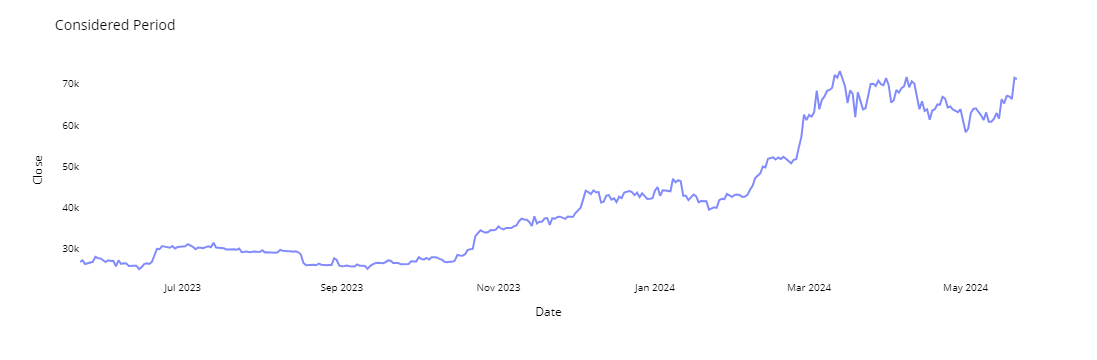

In [29]:
fig = px.line(data, x=data.Date, y=data.Close,labels={'date':'Date','close':'Close Price'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered Period', 
                  plot_bgcolor='white', font_size=10, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

##### Data Standardization

In [30]:
del data['Date']
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

In [33]:
data.shape

(366, 1)

##### Train Test Split

In [35]:
# split index
training_size = int(len(data) * 0.60)
test_size = len(data) - training_size

In [37]:
# Split the data
train_data = data[:training_size]
test_data = data[training_size:]

In [38]:
train_data.shape

(219, 1)

In [39]:
test_data.shape

(147, 1)

##### Create Dataset

In [40]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [41]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [45]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (203, 15)
y_train:  (203,)
X_test:  (131, 15)
y_test (131,)


In [46]:
# reshape input
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (203, 15, 1)
X_test:  (131, 15, 1)


#### 4. Model Building

In [50]:
model = Sequential()

# Add an Input layer
model.add(Input(shape=(None, 1)))
# Add the LSTM layer
model.add(LSTM(10, activation="relu"))
# Add the Dense layer
model.add(Dense(1))
# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam")
# Display the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape         ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)               │ (None, 10)           │         480 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dense_1 (Dense)             │ (None, 1)            │          11 │
└─────────────────────────────┴──────────────────────┴─────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0217 - val_loss: 0.2472
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - val_loss: 0.1507
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069 - val_loss: 0.0806
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0406
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0042 - val_loss: 0.0249
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - val_loss: 0.0187
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0166
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 0.0119
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 0.0083
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 0.0163
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.8809e-04 - val_loss: 0.0366
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7835e-04 

##### Training Loss vs Validation Loss

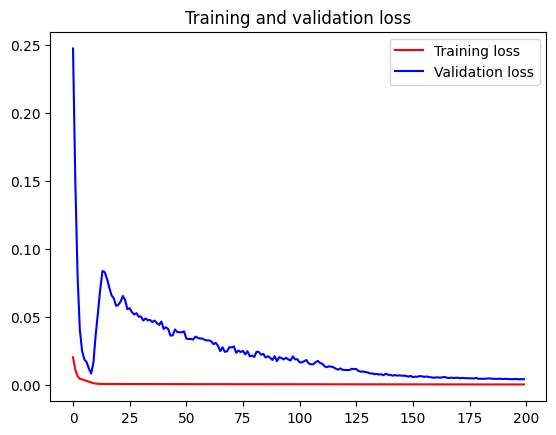

<Figure size 640x480 with 0 Axes>

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

#### 5. Predictions

In [53]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


((203, 1), (131, 1))

#### 6. Model Evaluation

In [54]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [55]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  718.3573828326496
Train data MSE:  516037.3294701739
Train data MAE:  477.7947294316504
-------------------------------------------------------------------------------------
Test data RMSE:  3072.925002539435
Test data MSE:  9442868.071231985
Test data MAE:  2352.468899116412


##### Variance Regression Score

In [56]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9828211977338744
Test data explained variance regression score: 0.9124375356174124


##### R Square Score for Regression

In [57]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9827489507441262
Test data R2 score: 0.9124367402708383


##### Mean Gamma Deviance (MGD) and Mean Poisson Deviance (MPD) Regression Loss 

In [58]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0004871489102969245
Test data MGD:  0.0025869481383084397
----------------------------------------------------------------------
Train data MPD:  15.602399918603355
Test data MPD:  154.68949452892878


#### 7. Comparisons of Close Price, Actual vs Predicted

Train predicted data:  (366, 1)
Test predicted data:  (366, 1)


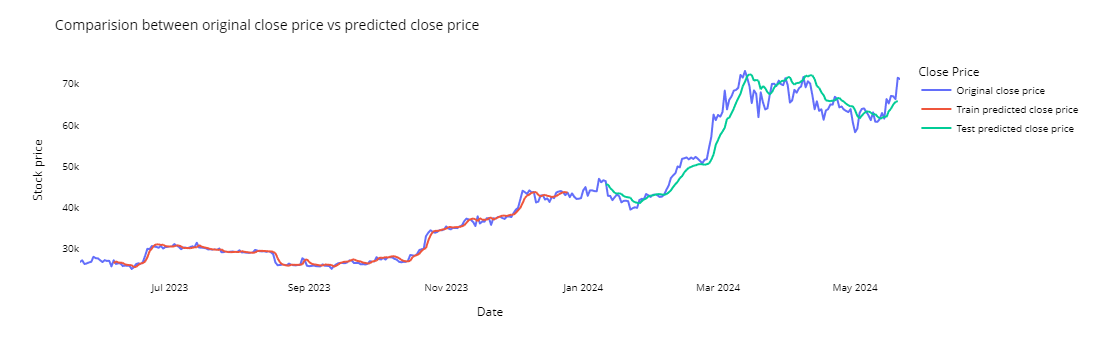

In [62]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': data_selected['Date'],
                       'original_close': data_selected['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=10, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#### Predicting Next 30 Days

In [63]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [64]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


#### Last 15 Days of Dataset and Next Predicted 30 Days

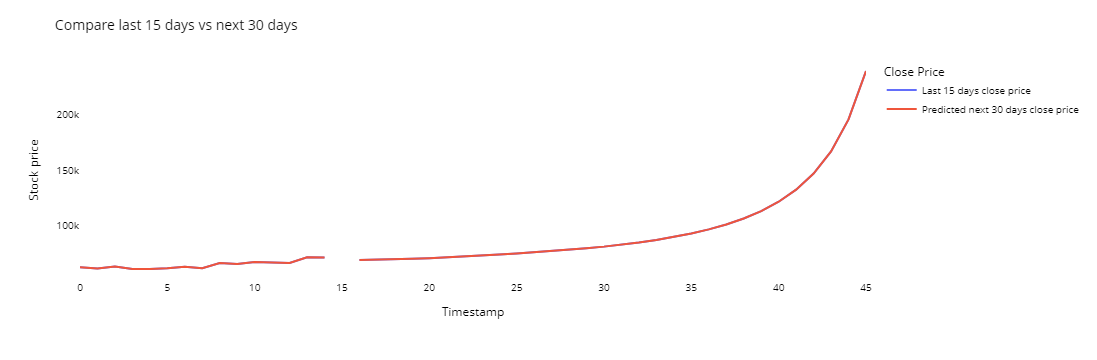

In [67]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(data[len(data)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=10, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#### Closing Stock Price with Next 30 Days Period of Prediction

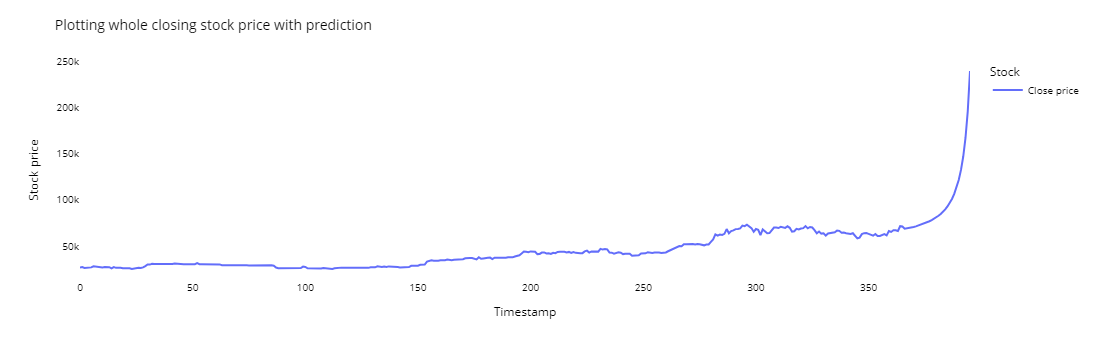

In [66]:
lstmdf=data.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=10, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()